# CESM2 Large Ensemble 2 Investiagtion

Daily files are located under `/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*` on the NCAR server.

__Variables analyzed__
- `WSPDSRFAV`: Horizontal total wind speed average at the surface [$m \ s^{-1}$]
- _WSPDSRFAV anomaly_: artificially constructed according to $x_i-\bar{x}_{\text{time}}$

In [72]:
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np
import pandas as pd
import pwlf
import xarray as xr
import cf_xarray as cfxr   # to use cf_xarray attributes
import regionmask
from glob import glob
import scienceplots
import string
%matplotlib inline
plt.style.use(["nature", "notebook"])

xr.set_options(keep_attrs=True)
%load_ext rich
from rich import print  # pretty printing
from tqdm import tqdm  # progress bar
import warnings  # deal with warnings

# To access collection
import dask
import intake
from dask_jobqueue import PBSCluster
from dask.distributed import Client

# Play nice with CMIP6 data
import xclim.ensembles as ensembles

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


## Helper functions

In [2]:
def mask_data(data, map, regions: None, drop=False, reverse=False):
    """Mask xarray data based on region names

    Args:
        data (xarray dataset): xarray dataset to mask
        map (regionmask): regionmask object
        regions (list or None): list of region names to mask. if None, all regions are taken. Defaults to None.
        drop (bool, optional): Whether to drop when masking. Defaults to False.
        reverse (bool, optional): Whether to mask the inverse of the regions. Defaults to False.

    Returns:
        xarray dataset: masked dataset
    """
    # Load the region mask
    mask = map.mask(data.cf['lat'], data.cf['lon'])
    # Extract keys for the region
    id_dict = map.region_ids
    # Get region names
    if regions is None:
        names = id_dict.keys()
    else:
        # Coerce region names to uppercase
        regions = [region.upper() for region in regions]
        names = [name for name in id_dict.keys() if str(name).upper() in regions]
        assert len(names) == len(regions), 'Not enough regions found'
    # Get the key for the regions
    keys = [id_dict[name] for name in names]
    # Apply the mask to the data
    if reverse:
        masked_data = data.where(~mask.isin(keys), drop=drop)
    else:
        masked_data = data.where(mask.isin(keys), drop=drop)
    return masked_data

## Spin up Dask cluster

In [10]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
num_jobs = 5
cluster = PBSCluster(
    job_name = 'valencig-dask-hpc',
    cores = 1,
    memory = '10GiB',
    local_directory = '/glade/u/home/valencig/spilled/',
    log_directory = '/glade/u/home/valencig/worker-logs/',
    queue = 'casper',
    walltime = '02:00:00', # Change wall time if needed
    interface = 'ext'
)


# Spin up workers
cluster.scale(jobs=num_jobs)

# Assign the cluster to our Client
client = Client(cluster)

# Block progress until workers have spawned
client.wait_for_workers(num_jobs)
client

<Client: 'tcp://128.117.208.112:34687' processes=4 threads=4, memory=40.00 GiB>

## Create ensemble

### Get simulation names

- `smbb`: smoothed biomass burning (more info [here](https://www.cesm.ucar.edu/community-projects/lens2))
- `cmip6`: classic CMIP6 forcings

In [5]:
# Get list of all files
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in all_files])
simulation_names

{'BSSP370cmip6', 'BSSP370smbb', 'BHISTsmbb', 'BHISTcmip6'}

### Load simulations

In [54]:
# Create dict to store all variants
simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files, parallel=True)
        # Remove 2100 (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014'))
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099'))
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    yearly = simulation.groupby('time.year').mean()  # No need to store daily data
    # Get anomaly
    anomaly = yearly - yearly.mean('year')
    # Add to dict
    simulations[sim] = anomaly.persist().compute()  # This step is slow but speeds up later computation

BHISTcmip6 - Loading members...: 100%|██████████| 14/14 [01:14<00:00,  5.30s/it]


## Time series plot

5 year running mean.

Error bars represent 25th and 75th quantiles.

Vertical line respresents GSOD derived reversal in stilling.

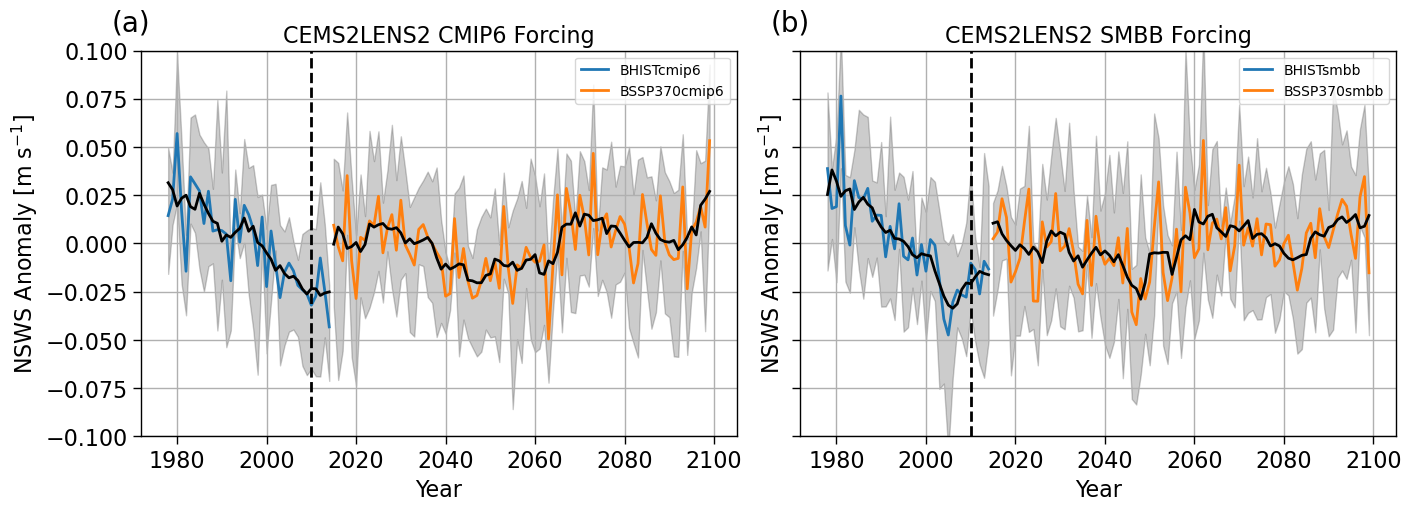

In [76]:
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

# Plot 1 - CMIP6
ax = axes[0]
for sim in ['BHISTcmip6', 'BSSP370cmip6']:
    # mask to land
    land = mask_data(simulations[sim], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Get timeseries
    land_ts = land.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land_ts)
    # Plot time series
    en_stats['WSPDSRFAV_mean'].plot(ax=ax, label=sim)
    en_stats['WSPDSRFAV_mean'].rolling(year=5, min_periods=1, center=True).mean().plot(ax=ax, color='k')
    # Percentiles
    per = ensembles.ensemble_percentiles(land_ts, values=[25, 75], split=True)
    ax.fill_between(per.year.values, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
# Plot 1 - Options
ax.set_title('CEMS2LENS2 CMIP6 Forcing')

# Plot 2 - SMBB
ax = axes[1]
for sim in ['BHISTsmbb', 'BSSP370smbb']:
    # mask to land
    land = mask_data(simulations[sim], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Get timeseries
    land_ts = land.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land_ts)
    # Plot time series
    en_stats['WSPDSRFAV_mean'].plot(ax=ax, label=sim)
    en_stats['WSPDSRFAV_mean'].rolling(year=5, min_periods=1, center=True).mean().plot(ax=ax, color='k')
    # Percentiles
    per = ensembles.ensemble_percentiles(land_ts, values=[25, 75], split=True)
    ax.fill_between(per.year.values, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
# Plot 2 - Options
ax.set_title('CEMS2LENS2 SMBB Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid()
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.set_ylim(-0.1, 0.1)
    ax.vlines(2010, -0.1, 0.1, color='k', linestyle='--')
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)

# Caption
print('5 year running mean.')
print('Error bars represent 25th and 75th quantiles.')
print('Vertical line respresents GSOD derived reversal in stilling.')

# Save figure
plt.savefig('figures/cems2lens2_time_series.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Kill Dask Cluster

In [9]:
client.shutdown()